# Outlier Detection and Final Scoring
This notebook will explore the SKlearn OPTICS implementation,   and look for a place to insert both the local outlier detection algorithm, and the DBCV score. 

## Local Outlier Factor
The local outlier factor is created by first calculating local reachability distances for all points. The local reachability distance is the inverse of the average reachability distance of the K-nearest neighbors from point p. This must be computed for each point before then calculating the local outlier factor. The local outlier factor is the average ratio of the local reachability distance of the nearest neighbors in relation to the local reachability distance of point p. 

In [1]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances  
%matplotlib inline
sample_set = 'STEGS'
x_set = 'seasonal'
data_loc = '../Sample_data/' + sample_set + '/pickle/'
figureloc = '/home/colin/Desktop/D_BOM/reports/figures/'
pkl_file = open(data_loc + 'sku_X' + x_set + '.pkl', 'rb')
pc = pickle.load(pkl_file)
print(pc.shape)
pc.drop_duplicates(inplace = True)

(5517, 10)


In [2]:
def remove_dups(data):
    #place duplicates extremely close, we cannot have duplciates for local outlier factor but would like to maintain density
    df= pd.DataFrame(data)
    dups = df.duplicated()
    noise = np.random.randn(dups[dups == True].shape[0],df.shape[1] )/20
    data[dups] = data[dups] + noise
    return df.values

In [3]:
nbrs = NearestNeighbors(n_neighbors=6,
                                algorithm='auto',
                                 metric='minkowski',

                       )
X = pc.values
#X = remove_dups(X)
nbrs.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=6, p=2, radius=1.0)

In [4]:
nbrs.kneighbors(
                X[:2], 6)[1][:, -1]

array([ 938, 1883])

In [5]:
nbrs.kneighbors(
                X[:2], 6)[1][1, :]

array([   1, 2582, 2445, 2017, 2198, 1883])

Find the fifth distance as core distance

In [6]:
from sklearn.utils import gen_batches, get_chunk_n_rows
from scipy.spatial.distance import pdist
n_samples = len(X)
core_distances = np.empty(n_samples)
core_distances.fill(np.nan)
local_reachability_ = np.empty(n_samples)
local_reachability_.fill(np.nan)
outlier_factor_ = np.empty(n_samples)
outlier_factor_.fill(np.nan)

chunk_n_rows = get_chunk_n_rows(row_bytes=16 * 5,
                                max_n_rows=n_samples)
slices = gen_batches(n_samples, chunk_n_rows)
for sl in slices:
    core_distances[sl] = nbrs.kneighbors(
        X[sl], 5 )[0][:, -1]

#compute local reachability for every point in the dataset
neighbors = nbrs.kneighbors(X, 5)
for i in np.arange(0, len(X)):
    nbr_idx = neighbors[1][i, 1:]
    dists = pairwise_distances(  X[i].reshape(1,-1), X[nbr_idx],
                                       'minkowski', n_jobs=None).ravel()
    v = np.vstack((dists,core_distances[nbr_idx]))
    r = np.amax(v, axis = 0)
    local_reachability_[i] = 1 / np.sum(r) / 5

    
#compute local outlier factor
for i in np.arange(0, len(X)):
    nbr_idx = neighbors[1][i,]
    outlier_factor_[i] = np.sum(local_reachability_[nbr_idx] / local_reachability_[i]) / 5
    

In [7]:
def _set_reach_dist( point_index, processed, X, nbrs):
        P = X[point_index:point_index + 1]
        # Assume that radius_neighbors is faster without distances
        # and we don't need all distances, nevertheless, this means
        # we may be doing some work twice.
        indices = nbrs.radius_neighbors(P, radius=100,
                                        return_distance=False)[0]
        # Getting indices of neighbors that have not been processed
        unproc = np.compress((~np.take(processed, indices)).ravel(),
                             indices, axis=0)
        # Neighbors of current point are already processed.
        if not unproc.size:
            return
        
        # Only compute distances to unprocessed neighbors:
        dists = pairwise_distances(P, np.take(X, unproc, axis=0),
                                       'minkowski', n_jobs=None).ravel()
        
        
        rdists = np.maximum(dists, core_distances[point_index])
        
        improved = np.where(rdists < np.take(reachability_, unproc))
        
        reachability_[unproc[improved]] = rdists[improved]
        predecessor_[unproc[improved]] = point_index
        

In [8]:
labels_ = np.full(n_samples, -1, dtype=int)
reachability_ = np.empty(n_samples)
reachability_.fill(np.inf)
predecessor_ = np.empty(n_samples, dtype=int)
predecessor_.fill(-1)      
processed = np.zeros(X.shape[0], dtype=bool)
ordering = np.zeros(X.shape[0], dtype=int)
for ordering_idx in range(X.shape[0]):
    # Choose next based on smallest reachability distance
    index = np.where(processed == 0)[0]
    point = index[np.argmin(reachability_[index])]   
    processed[point] = True
    ordering[ordering_idx] = point
    if core_distances[point] != np.inf:
        _set_reach_dist(point, processed, X, nbrs)


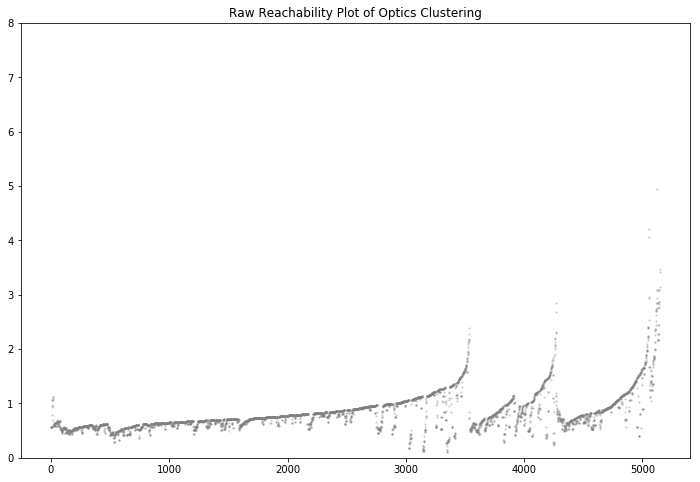

In [9]:
plt.figure(figsize =( 12,8))
plt.scatter(np.arange(0, len(reachability_)), reachability_[ordering], color = 'gray', s= 2,  alpha = .25)
plt.title('Raw Reachability Plot of Optics Clustering')
plt.ylim(0, 8)
plt.savefig(figureloc + 'RawReachability.png')
plt.show()

In [10]:
of = outlier_factor_

In [11]:
of

array([1.01227216, 1.14357641, 1.0823646 , ..., 1.04233129, 1.03238366,
       1.02657385])

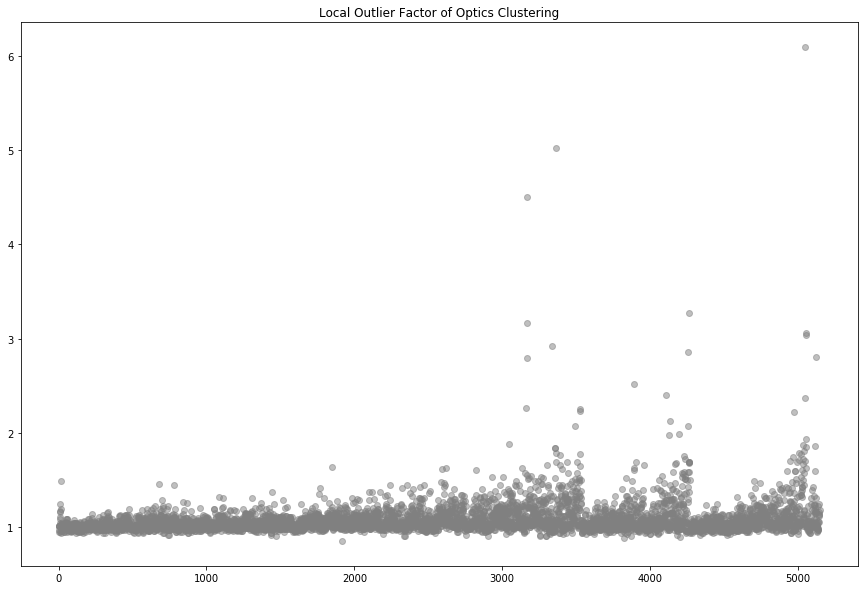

In [12]:
plt.figure(figsize = (15,10))
plt.scatter(np.arange(0, len(of)), of[ordering], color = 'gray', alpha = .5) 
plt.title('Local Outlier Factor of Optics Clustering')
plt.savefig(figureloc + 'LocalOutlierGraph.png')

Text(0.5, 1.0, 'Local Outlier Factor Histogram of Optics Plot')

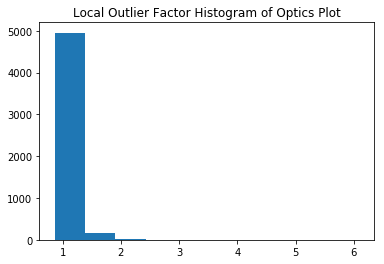

In [13]:
plt.hist(of, bins = 10)
plt.title('Local Outlier Factor Histogram of Optics Plot')

In [14]:
ind = np.where((of > 2))
ind

(array([ 153,  956, 1567, 1568, 1699, 1792, 1925, 2575, 3277, 3342, 3607,
        3718, 3729, 3791, 3917, 4019, 4250, 4598, 4969, 4981, 5111]),)

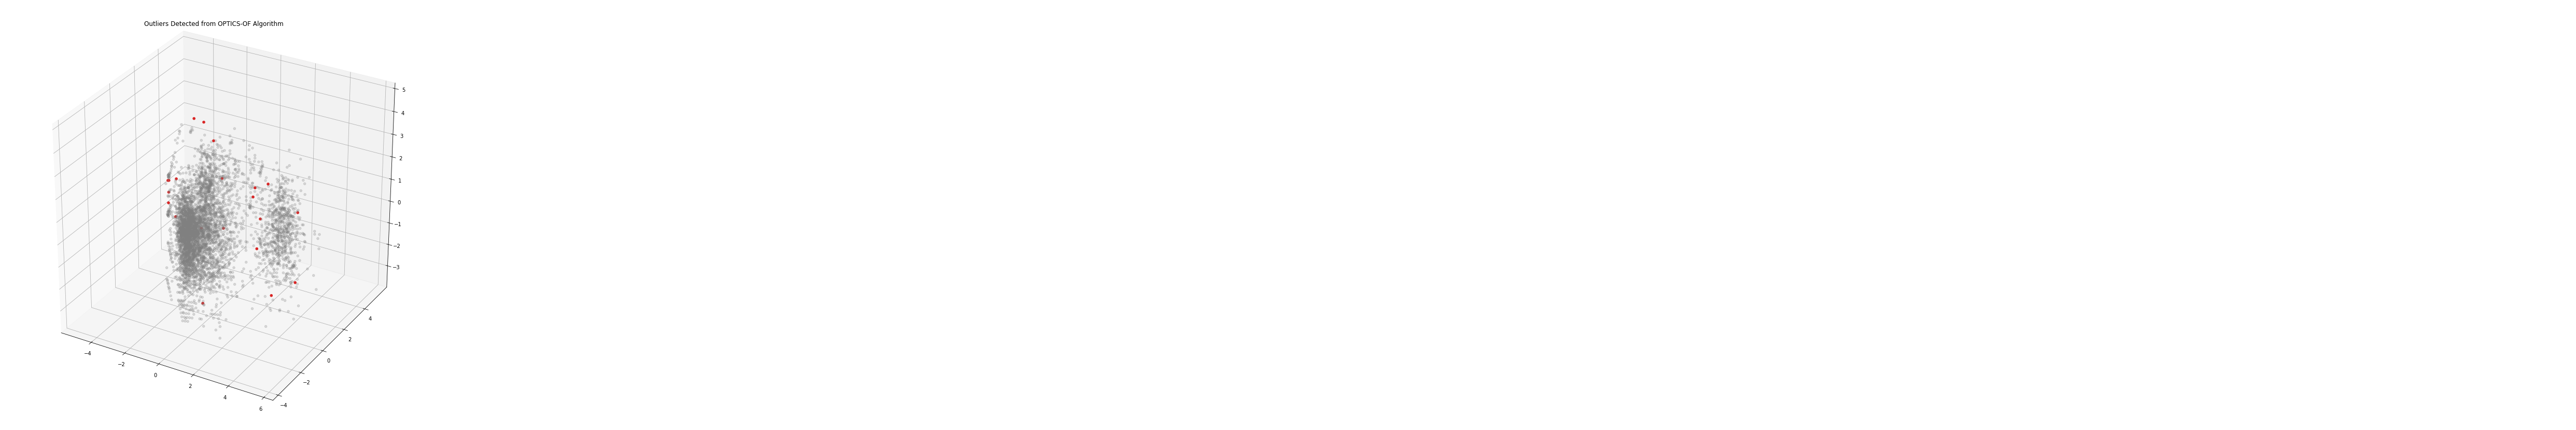

In [15]:
#plot outliers as red
from mpl_toolkits.mplot3d import Axes3D
fig3D = plt.figure(figsize=(15, 15))
ax = fig3D.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1],X[:, 2], c = 'gray',  alpha = .25)
ax.scatter(X[ind, 0], X[ind, 1],X[ind, 2], c = 'red',  alpha = 1)
fig3D.suptitle('Outliers Detected from OPTICS-OF Algorithm', y = .85)
plt.savefig(figureloc + 'localoutlier3D.png')

The local outlier factor appears to be working, not selecting any points within the main clusters, but those that seem to be on the outskirts. It is hard to visually see why a point is selected as a local outlier however, because it is relying on the scores of the K-nearest neighbors as well. 

# Density Based Clustering Validation

The process for calculating the density based clustering validation score is as follows.
for each cluster: <br>
   -computing the mutual reachability distance <br>
   -creating a mutual reachability distance graph G <br>
   -creating the minimum spanning tree of G <br>
   -calculating the density sparseness <br>
   -calculating the density separation <br>
   -calculate the validity index <br>

then we use the scores of all clusters to determine the weighted average of all clusters. In this section, we'll just explore how they are created. In the final product, much of this will be computed in line with clustering, so we don't have to do things twice over like calculating pairwise distances. 

In [16]:
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csgraph

In [17]:
X[0, :]

array([-0.4176616 , -1.99724428, -1.04366564, -0.8269871 ,  2.42557071,
        0.27946387, -0.81823195, -2.04835658,  0.10487593,  1.59001956])

In [18]:
# first lets get labels from the example above
import sys 
sys.path.insert(0, '/home/colin/Desktop/D_BOM/src')
from OPTICS import optics

clust = optics.OPTICS(min_cluster_size = .03)
clust.fit(X)
labels = clust.labels_

In [19]:
x = pd.DataFrame(labels)

In [20]:
x.columns = ['pc']

In [21]:
x['pc'].value_counts()

 0    2973
-1     990
 3     615
 1     374
 2     195
Name: pc, dtype: int64

In [22]:
# return pairwise distances for all
dists = pairwise_distances(X, X, 'minkowski')

In [23]:
mutual_reachaility = np.empty((dists.shape))

In [24]:
rownum = 0
row = dists[rownum, :]
i_core = np.empty(dists.shape[0])
i_core.fill(core_distances[rownum])
j_core = core_distances.ravel()
npmut = np.vstack((row, i_core, j_core))

In [25]:
i_core.shape

(5147,)

In [26]:
j_core.shape

(5147,)

In [27]:
r = np.amax(npmut, axis = 0)

In [28]:
graph= np.empty(dists.shape)
for rownum in np.arange(0, dists.shape[0]):
    row = dists[rownum, :]
    i_core = np.empty(dists.shape[0])
    i_core.fill(core_distances[rownum])
    j_core = core_distances.ravel()
    npmut = np.vstack((row, i_core, j_core))
    r = np.amax(npmut, axis = 0)
    graph[rownum, :] = r
    

mst_ = minimum_spanning_tree(graph).toarray()
mst = mst_ + np.transpose(mst_)

In [29]:
#calculate cluster sparseness
def calc_sparseness(MST, clust):
    indices = np.where(labels == clust)[0]
    cluster_MST = MST[indices][:, indices]
    cluster_density_sparseness = np.max(cluster_MST)
    return cluster_density_sparseness

In [30]:
calc_sparseness(mst, 0)

1.6438196578367688

In [31]:
def cluster_separation(i, j, tree):
    indices_i = np.where(labels == i)[0]
    indices_j = np.where(labels == j)[0]
    shortest_paths = csgraph.dijkstra(tree, indices=indices_i)
    relevant_paths = shortest_paths[:, indices_j]
    density_separation = np.min(relevant_paths)
    return density_separation


In [32]:
cluster_separation(0,1, mst)

3.2244322740746467

In [33]:
clusts = np.arange(0, len(np.unique(labels)) - 1)
clusts

array([0, 1, 2, 3])

In [34]:
def calc_index(cluster, mst):
    min_density_separation = np.inf
    for j in clusts:
        if j != cluster:
            cluster_density_separation = cluster_separation(cluster, j, mst)
            if cluster_density_separation < min_density_separation:
                min_density_separation = cluster_density_separation
                
    cluster_sparseness = calc_sparseness(mst, cluster)
    numerator = min_density_separation - cluster_sparseness
    denominator = np.max([min_density_separation, cluster_sparseness])
    cluster_validity = numerator / denominator
    return cluster_validity

def calc_score():
    n_samples = len(labels)
    validity_index = 0
    for label in clusts:
        print('label {}'.format(label))
        fraction = np.sum(labels == label) / float(n_samples)
        print('frac:{}'.format(fraction))
        cluster_validity = calc_index(label, mst)
        print('validity: {}'.format(cluster_validity))
        validity_index += fraction * cluster_validity
    return validity_index
        

In [35]:
score = calc_score()

label 0
frac:0.577618029920342
validity: 0.49019873326118624
label 1
frac:0.07266368758500097
validity: -0.2671800007754627
label 2
frac:0.037886147270254515
validity: -0.29711874351136486
label 3
frac:0.11948707985234117
validity: 0.5857818349322018


In [36]:
score

0.3224700188836354

This score appears to be valid, as it is supposed to be between -1 and 1. All vaidity scores above are also between -1 and 1. 

In [37]:
X = pd.DataFrame(X)

In [38]:
X['clust'] = labels

In [39]:
X['clust'].nunique()

5